In [1]:
### LIBRERÍAS

import os
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Paths

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
IMG_TRAIN_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'train', 'images')
IMG_TEST_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'test', 'images')
IMG_VAL_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'val', 'images')
LBL_TRAIN_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'train', 'labels')
LBL_TEST_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'test', 'labels')
LBL_VAL_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'val', 'labels')

# Análisis Exploratorio de Datos

In [3]:
print("Train images:", len(glob.glob(os.path.join(IMG_TRAIN_DIR, '*.png'))))
print("Validation images:", len(glob.glob(os.path.join(IMG_VAL_DIR, '*.png'))))
print("Test images:", len(glob.glob(os.path.join(IMG_TEST_DIR, '*.png'))))

Train images: 3617
Validation images: 452
Test images: 453


In [28]:
# las labels se encuentran dentro de archivos .txt, por lo que se debe leer cada archivo y extraer la información de las etiquetas
# el nombre del archivo de la imagen y el archivo de la etiqueta son iguales
# puede haber más de una etiqueta por imagen, por lo que se debe leer cada línea del archivo de etiquetas

def load_labels(label_dir):
    labels = []
    for label_file in tqdm(glob.glob(os.path.join(label_dir, '*.txt')), desc="Loading labels"):
        with open(label_file, 'r') as f:
            labels_img = [line.strip() for line in f if line.strip() != '']
            
        if labels_img:
            labels.append(labels_img)
    return labels

print("\nTRAINING")
labels_train = load_labels(LBL_TRAIN_DIR)
print("There are", len(labels_train), "images with boats")
print("The mean number of boats in those images is ", np.mean([len(l) for l in labels_train]))

print("\nVALIDATION")
labels_val = load_labels(LBL_VAL_DIR)
print("There are", len(labels_val), "images with boats")
print("The mean number of boats in those images is ", np.mean([len(l) for l in labels_val]))

print("\nTESTING")
labels_test = load_labels(LBL_TEST_DIR)
print("There are", len(labels_test), "images with boats")
print("The mean number of boats in those images is ", np.mean([len(l) for l in labels_test]))


TRAINING


Loading labels:   0%|          | 0/3617 [00:00<?, ?it/s]

Loading labels: 100%|██████████| 3617/3617 [00:00<00:00, 6904.93it/s]


There are 1888 images with boats
The mean number of boats in those images is  1.7309322033898304

VALIDATION


Loading labels: 100%|██████████| 452/452 [00:00<00:00, 6405.18it/s]


There are 237 images with boats
The mean number of boats in those images is  1.6160337552742616

TESTING


Loading labels: 100%|██████████| 453/453 [00:00<00:00, 7105.75it/s]

There are 243 images with boats
The mean number of boats in those images is  1.6584362139917694


La mitad de las imágenes no poseen barcos, pero las imágenes que sí tienen, pueden contener más de uno.

C:\Users\gonza\AppData\Local\Temp\ipykernel_6408\1436544970.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=num_barcos, palette='Set2')    # Una barra por cada valor distinto, con 20 colores distintos


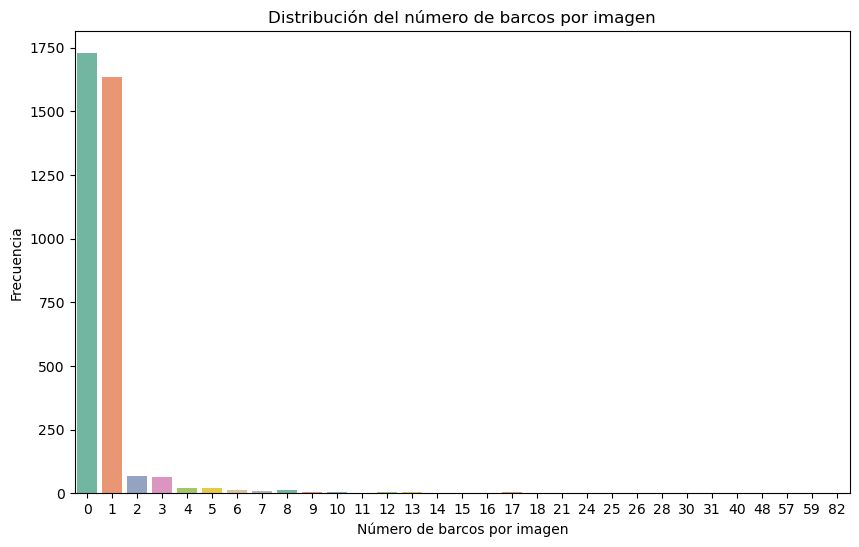

In [53]:

num_barcos = [len(l) for l in labels_train]
#añado las imagenes con 0 barcos
for i in range(len(labels_train), 3617):
    num_barcos.append(0)

# distribución del numero de barcos por imagen en train
plt.figure(figsize=(10, 6))
sns.countplot(x=num_barcos, palette='Set2')    # Una barra por cada valor distinto, con 20 colores distintos

plt.xlabel('Número de barcos por imagen')
plt.ylabel('Frecuencia')
plt.title('Distribución del número de barcos por imagen')
plt.show()


Existen imágenes con incluso 82 barcos, aunque vemos que la gran mayoría tienen uno o ninguno.

In [29]:
#leer clases de las etiquetas
def get_classes(labels):
    classes = set()
    for label in labels:
        for l in label:
            classes.add(l.split()[0])
    return list(classes)

classes_train = get_classes(labels_train)
classes_train


['0']

Solo hay una clase en el conjunto de datos, que corresponde a la detección de un barco.

Dimensiones de las imágenes en general: 512x512 píxeles.

(momstrar grafica con dimensiones pa comprobar)

# MACHINE LEARNING (CLASIFICACIÓN)

En primer lugar ajustaremos un modelo de machine learning (SVM) para hacer una clasificación binaria y está basado en la extracción de características HOG. Es decir, el objetivo es determinar si una foto tiene barco o no. En un primer momento, es de suponer que deste no debería ser un muy buen modelo, ya que no se está usando ningún método de deep learning para esta clasificación.

In [3]:
# Función para saber si hay barco
def has_boat(label_path):
    return os.path.exists(label_path) and os.path.getsize(label_path) > 0

# Extraer características HOG usando Pillow
def extract_features(image_path):
    image = Image.open(image_path).convert("L")  # Convertir a escala de grises
    image = image.resize((128, 128))  # Redimensionar
    image_np = np.array(image)

    features, _ = hog(image_np,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True)
    return features

In [4]:
# Cargar imágenes de entrenamiento
X_train, y_train = [], []
train_image_paths = glob.glob(os.path.join(IMG_TRAIN_DIR, '*.png'))

for img_path in tqdm(train_image_paths, desc="Extrayendo características de entrenamiento"):
    filename = os.path.splitext(os.path.basename(img_path))[0] + '.txt'
    label_path = os.path.join(LBL_TRAIN_DIR, filename)  # Ruta de etiquetas de entrenamiento

    label = int(has_boat(label_path))
    features = extract_features(img_path)

    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Cargar imágenes de prueba
X_test, y_test = [], []
test_image_paths = glob.glob(os.path.join(IMG_TEST_DIR, '*.png'))

for img_path in tqdm(test_image_paths, desc="Extrayendo características de test"):
    filename = os.path.splitext(os.path.basename(img_path))[0] + '.txt'
    label_path = os.path.join(LBL_TEST_DIR, filename)  # Ruta de etiquetas de prueba

    label = int(has_boat(label_path))  
    features = extract_features(img_path)

    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

Extrayendo características de test: 100%|████████████████████████████████████████████| 453/453 [00:48<00:00,  9.31it/s]


In [5]:
# Modelo
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

# Evaluación en conjunto de prueba
y_pred = model.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=["No barco", "Barco"]))


Reporte de clasificación:
              precision    recall  f1-score   support

    No barco       0.58      0.57      0.57       210
       Barco       0.63      0.64      0.64       243

    accuracy                           0.61       453
   macro avg       0.60      0.60      0.60       453
weighted avg       0.61      0.61      0.61       453



Obtenemos un accurcay del 61%, un poco más del 50% que sería puro azar, por lo tanto confirmamos nuestras primeras sospechas de que un método de machine learning no es el más adecuado para esta tarea.

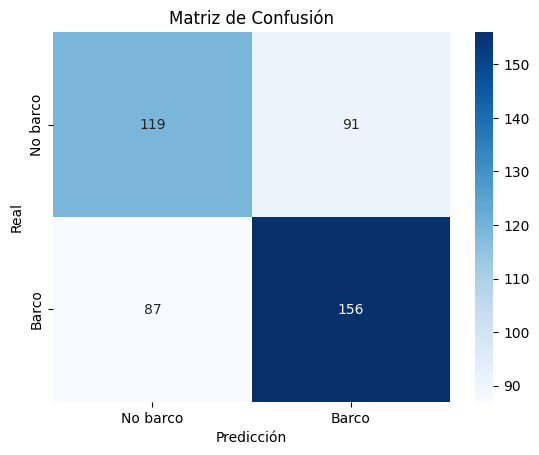

In [6]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No barco", "Barco"], yticklabels=["No barco", "Barco"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# DEEP LEARNING (CLASIFICACIÓN)

Ahora ajustaremos un modelo de deep learning (una CNN) y veremos si ofrece mejores resultados que el modelo anterior, lo cual es de esperar.

In [3]:
IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class BoatDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, '*.png')))
        self.label_dir = label_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def has_boat(self, label_path):
        if not os.path.exists(label_path):
            return 0
        with open(label_path, 'r') as f:
            return int(bool(f.read().strip()))

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        filename = os.path.splitext(os.path.basename(img_path))[0] + '.txt'
        label_path = os.path.join(self.label_dir, filename)

        image = Image.open(img_path).convert('RGB')
        label = self.has_boat(label_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Cargamos los datasets de train, validation y test
train_dataset = BoatDataset(IMG_TRAIN_DIR, LBL_TRAIN_DIR, transform)
val_dataset = BoatDataset(IMG_VAL_DIR, LBL_VAL_DIR, transform)
test_dataset = BoatDataset(IMG_TEST_DIR, LBL_TEST_DIR, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [14]:
class ImprovedBoatClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)


In [15]:
# Inicializar listas para guardar métricas
train_losses = []
train_accuracies = []

# Entrenamos la CNN
model = ImprovedBoatClassifier().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.float().to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images).view(-1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


Epoch 1/15, Loss: 0.6610, Accuracy: 0.5964
Epoch 2/15, Loss: 0.6304, Accuracy: 0.6417
Epoch 3/15, Loss: 0.6196, Accuracy: 0.6563
Epoch 4/15, Loss: 0.6060, Accuracy: 0.6605
Epoch 5/15, Loss: 0.5928, Accuracy: 0.6718
Epoch 6/15, Loss: 0.5771, Accuracy: 0.6879
Epoch 7/15, Loss: 0.5542, Accuracy: 0.7000
Epoch 8/15, Loss: 0.5265, Accuracy: 0.7230
Epoch 9/15, Loss: 0.4789, Accuracy: 0.7597
Epoch 10/15, Loss: 0.4339, Accuracy: 0.7935
Epoch 11/15, Loss: 0.3763, Accuracy: 0.8233
Epoch 12/15, Loss: 0.3314, Accuracy: 0.8537
Epoch 13/15, Loss: 0.2756, Accuracy: 0.8808
Epoch 14/15, Loss: 0.2422, Accuracy: 0.8974
Epoch 15/15, Loss: 0.2001, Accuracy: 0.9165


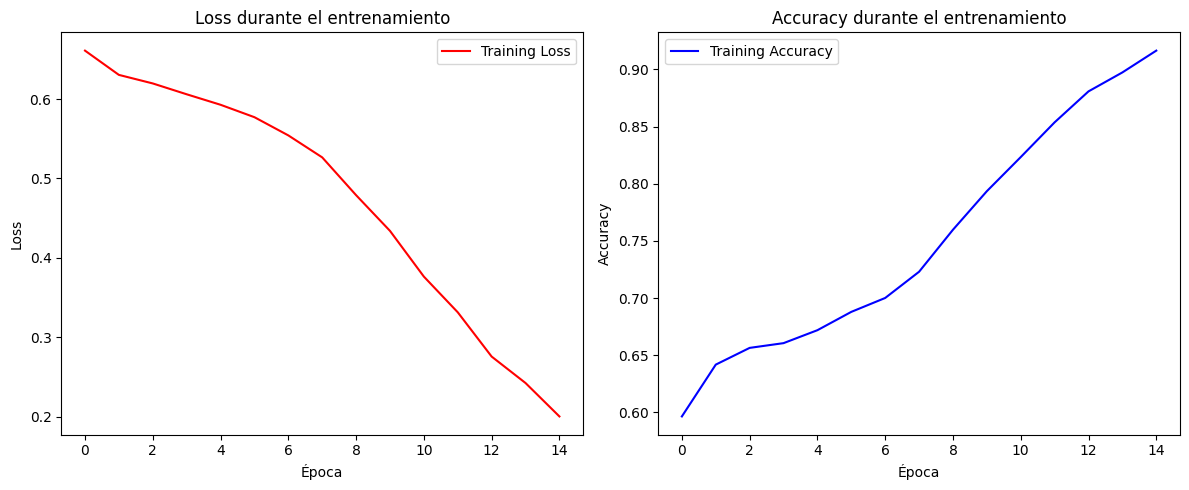

In [16]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='red')
plt.title('Loss durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Vemos como el loss va decayendo a lo largo de las épocas, mientras que el accuracy va en aumento. El entrenamiento concluye con un training accuracy del 91%. Este modelo fue entrenado mediante cross-validation con un grid de hiperparámetros, pero debido al tiempo que requería se optó por poner directamente el mejor resultado.

In [17]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = (outputs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=['No Boat', 'Boat']))


              precision    recall  f1-score   support

     No Boat       0.75      0.83      0.79       210
        Boat       0.84      0.76      0.80       243

    accuracy                           0.79       453
   macro avg       0.79      0.80      0.79       453
weighted avg       0.80      0.79      0.79       453



Aquí observamos que tenemos un 79% de accuracy en test, por lo que podríamos argumentar que sí existe un ligero sobreaprendizaje. Así y todo, este fue le mejor modelo que pudimos obtener usando una CNN.

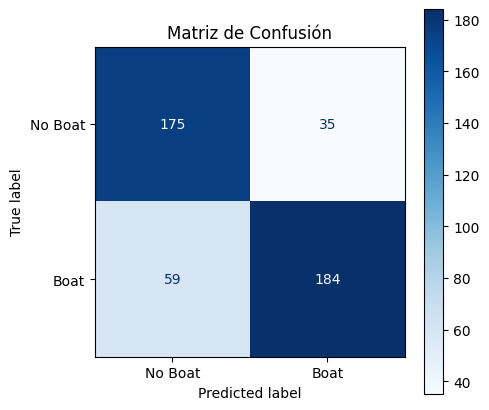

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Boat', 'Boat'])

# Visualización
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Matriz de Confusión")
plt.show()

# DEEP LEARNING: YOLO

You Only Look Once (YOLO) es un algoritmo de detección de objetos en imágenes. A diferencia de otros métodos que analizan la imagen en varias etapas, YOLO trata la detección como un problema de regresión único, lo que lo hace más rápido y eficiente.

Existen múltiples versiones de YOLO, cada una mejorando la precisión y velocidad del modelo. Se usará YOLO v8.

In [4]:
from ultralytics import YOLO
import torch
import cv2

In [5]:
# gpu o cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


Carga del modelo YOLO v8 preentrenado. Este modelo ha sido entrenado en el conjunto de datos COCO, que contiene 80 clases de objetos. Se realizará un ajuste fino (fine-tuning) del modelo para adaptarlo a nuestro conjunto de datos específico, que solo tiene una clase: barco.

In [7]:
model = YOLO('yolov8n.pt') # modelo mas pequeño

## Entrenamiento

In [7]:
YAML_DATA = os.path.join(BASE_DIR, 'data', 'data.yaml')

# Ajuste los hiperparámetros y entrenamiento del modelo
#    - data: data.yaml
#    - epochs: nº de épocas 
#    - imgsz: tamaño de lado de las imágenes 
#    - batch: tamaño de lote 
#    - device: GPU o CPU
model.train(
    data=YAML_DATA,
    epochs=50,
    imgsz=512,
    batch=32,
    device=device,
    name='first-boat-detection-nano',
)

New https://pypi.org/project/ultralytics/8.3.127 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.126  Python-3.12.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scal

100%|██████████| 755k/755k [00:00<00:00, 8.10MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    751507  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 21.2MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.40.0 ms, read: 18.413.5 MB/s, size: 282.7 KB)


train: Scanning C:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\train\labels... 3617 images, 1729 backgrounds, 0 corrupt: 100%|██████████| 3617/3617 [00:08<00:00, 419.85it/s]


train: New cache created: C:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\train\labels.cache
val: Fast image access  (ping: 0.50.3 ms, read: 16.610.1 MB/s, size: 333.8 KB)


val: Scanning C:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\val\labels... 452 images, 215 backgrounds, 0 corrupt: 100%|██████████| 452/452 [00:01<00:00, 384.83it/s]

val: New cache created: C:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\val\labels.cache


Plotting labels to runs\detect\first-boat-detection-nano\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs\detect\first-boat-detection-nano
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.57G      2.177       5.15      1.053          1        512: 100%|██████████| 227/227 [00:39<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.63it/s]

                   all        452        383      0.685      0.514      0.539      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       1.6G      2.202      2.571      1.095          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.29it/s]

                   all        452        383      0.661      0.538      0.577      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       1.6G      2.218      1.796      1.108          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.34it/s]

                   all        452        383      0.664      0.579      0.584      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.74G      2.157      1.596       1.09          1        512: 100%|██████████| 227/227 [00:31<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.55it/s]

                   all        452        383      0.734      0.633      0.677      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.76G      2.121      1.489      1.073          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.31it/s]

                   all        452        383       0.73      0.634      0.673       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.77G      2.091      1.419      1.082          0        512: 100%|██████████| 227/227 [00:31<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.50it/s]

                   all        452        383      0.604      0.572      0.561      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.78G      2.086      1.456      1.076          1        512: 100%|██████████| 227/227 [00:32<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.48it/s]

                   all        452        383      0.651      0.595      0.625      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.92G      2.053      1.419      1.068          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.58it/s]

                   all        452        383      0.758      0.597      0.661      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.93G       2.01      1.347      1.051          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.57it/s]

                   all        452        383       0.72      0.587      0.652      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.95G      2.032      1.357       1.06          1        512: 100%|██████████| 227/227 [00:31<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.84it/s]

                   all        452        383      0.678      0.533       0.59      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.96G       1.98      1.275      1.047          1        512: 100%|██████████| 227/227 [00:32<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.63it/s]

                   all        452        383       0.79      0.585      0.688      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.98G      2.013      1.273      1.053          1        512: 100%|██████████| 227/227 [00:32<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.17it/s]

                   all        452        383      0.779      0.663      0.717       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         2G      1.955      1.222      1.018          0        512: 100%|██████████| 227/227 [00:30<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  6.14it/s]

                   all        452        383      0.719      0.658      0.695      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.02G      1.948      1.224      1.047          1        512: 100%|██████████| 227/227 [00:29<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  6.30it/s]

                   all        452        383      0.815      0.608      0.702      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.03G      1.921      1.196      1.018          1        512: 100%|██████████| 227/227 [00:29<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.92it/s]

                   all        452        383      0.777      0.679      0.749      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.05G      1.928      1.204       1.02          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]

                   all        452        383      0.766       0.71      0.752      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.07G      1.909      1.196      1.006          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.81it/s]

                   all        452        383      0.831      0.658      0.744      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.09G      1.891      1.172      1.016          0        512: 100%|██████████| 227/227 [00:31<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.42it/s]

                   all        452        383      0.775      0.621       0.69      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.09G      1.893       1.18       1.02          1        512: 100%|██████████| 227/227 [00:32<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.16it/s]

                   all        452        383      0.615      0.616      0.622      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.12G      1.916      1.127       1.02          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.42it/s]

                   all        452        383      0.846      0.621      0.748      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.14G      1.863      1.113     0.9999          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.62it/s]

                   all        452        383      0.783        0.7      0.749      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.15G      1.849      1.113     0.9865          1        512: 100%|██████████| 227/227 [00:31<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.55it/s]

                   all        452        383      0.765      0.687      0.732      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.16G      1.856      1.098      1.001          3        512: 100%|██████████| 227/227 [00:32<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.59it/s]

                   all        452        383      0.764      0.627      0.719       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.19G      1.881       1.08     0.9939          2        512: 100%|██████████| 227/227 [00:32<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]

                   all        452        383       0.85      0.682       0.78      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.21G      1.826      1.058     0.9991          0        512: 100%|██████████| 227/227 [00:31<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.64it/s]

                   all        452        383      0.853      0.712      0.777      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.22G      1.825      1.046     0.9952          1        512: 100%|██████████| 227/227 [00:32<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]

                   all        452        383      0.855      0.681      0.753      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.23G      1.816      1.061      0.995          0        512: 100%|██████████| 227/227 [00:32<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.51it/s]

                   all        452        383       0.81        0.7      0.753      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.26G      1.823      1.032     0.9975          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.60it/s]

                   all        452        383      0.842      0.705      0.786      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.27G      1.756      1.044     0.9828          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.21it/s]

                   all        452        383      0.813      0.668      0.756      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.29G      1.833       1.02     0.9963          1        512: 100%|██████████| 227/227 [00:32<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]

                   all        452        383      0.813      0.681      0.771       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.3G      1.785      1.014     0.9888          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.75it/s]

                   all        452        383      0.885      0.661      0.783      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.33G      1.813       1.02     0.9852          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.35it/s]

                   all        452        383      0.882      0.686      0.786      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.34G      1.806      1.012     0.9932         10        512: 100%|██████████| 227/227 [00:33<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.16it/s]

                   all        452        383       0.83      0.697      0.787      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.36G      1.772     0.9743     0.9895          0        512: 100%|██████████| 227/227 [00:34<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.38it/s]

                   all        452        383       0.82       0.69      0.764      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.57G      1.763     0.9789     0.9746          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.37it/s]

                   all        452        383      0.812      0.699      0.771      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.6G      1.751     0.9638     0.9831          1        512: 100%|██████████| 227/227 [00:34<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.97it/s]

                   all        452        383      0.826      0.743      0.805      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.62G      1.749     0.9596     0.9732          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.53it/s]

                   all        452        383      0.862      0.717      0.806      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.63G      1.744      0.954     0.9787          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]

                   all        452        383      0.835      0.736      0.814      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.64G      1.734     0.9252     0.9715          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.57it/s]

                   all        452        383      0.915      0.675      0.809      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.67G      1.742     0.9359     0.9713          0        512: 100%|██████████| 227/227 [00:32<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.16it/s]

                   all        452        383       0.84      0.724      0.813      0.354


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.69G      1.703     0.9363     0.9823          0        512: 100%|██████████| 227/227 [00:32<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]

                   all        452        383      0.879      0.697        0.8      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.7G      1.704     0.9214     0.9824          1        512: 100%|██████████| 227/227 [00:33<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.61it/s]

                   all        452        383      0.892      0.711      0.818      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.71G      1.681     0.8846      0.985          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.14it/s]

                   all        452        383      0.852      0.749      0.815      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.74G       1.68     0.8963     0.9782          1        512: 100%|██████████| 227/227 [00:32<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.38it/s]

                   all        452        383      0.855      0.744      0.815      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.75G      1.668     0.8663     0.9895          1        512: 100%|██████████| 227/227 [00:32<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.87it/s]

                   all        452        383      0.882       0.76      0.838      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.77G       1.65     0.8557     0.9794          1        512: 100%|██████████| 227/227 [00:31<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.62it/s]

                   all        452        383      0.856      0.734      0.819      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.78G      1.646     0.8693     0.9876          1        512: 100%|██████████| 227/227 [00:31<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.80it/s]

                   all        452        383      0.871      0.747      0.818      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.8G      1.619     0.8483     0.9653          4        512: 100%|██████████| 227/227 [00:31<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]

                   all        452        383      0.845      0.755      0.803      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.82G      1.596     0.8385      0.949          0        512: 100%|██████████| 227/227 [00:31<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.83it/s]

                   all        452        383      0.821      0.766      0.808      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.84G      1.604     0.8178     0.9739          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]

                   all        452        383      0.838       0.77      0.811      0.359



50 epochs completed in 0.509 hours.
Optimizer stripped from runs\detect\first-boat-detection-nano\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\first-boat-detection-nano\weights\best.pt, 6.2MB

Validating runs\detect\first-boat-detection-nano\weights\best.pt...
Ultralytics 8.3.126  Python-3.12.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]


                   all        452        383      0.893       0.76      0.838      0.365
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\first-boat-detection-nano


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000234F1E4D4C0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

Las gráficas del entrenamiento se encuentran en el directorio runs

Matriz de confusión:

![Matriz de confusión](runs/detect/first-boat-detection-nano/confusion_matrix.png)

Métricas de entrenamiento:
![Métricas de entrenamiento](runs/detect/first-boat-detection-nano/results.png)

# Evaluación del modelo
Vamos a ver como se comporta con los datos de test.

In [9]:
path_modelo = os.path.join(BASE_DIR, 'code/runs/detect/first-boat-detection-nano/weights/best.pt')

In [10]:
# Evaluación del modelo con imagenes de test
model = YOLO(path_modelo)

In [12]:
#probar con una imagen de test y mostrar imagen
img_path = os.path.join(IMG_TEST_DIR, 'x0099.png')
results = model.predict(img_path, conf=0.5, iou=0.5, device=device)

# Obtener la imagen con los bounding boxes ya dibujados
#    La función plot() devuelve un ndarray BGR con las detecciones
annotated_img = results[0].plot()

# Mostrar imagen con OpenCV
window_name = "Detecciones de barcos"
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.imshow(window_name, annotated_img)
 # espera a que pulses una tecla cualquiera o que cierres la ventana manualmente
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q') or cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) < 1:
        break
# Cierra la ventana y libera los recursos
cv2.destroyAllWindows()


image 1/1 c:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\test\images\x0099.png: 512x512 1 boat, 22.8ms
Speed: 2.5ms preprocess, 22.8ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 512)


Velocidad de inferencia extremadamente rápida, 0.02 segundos por imagen.

## Métricas en el conjunto de test

In [ ]:
# aplicar modelo a todo el conjunto de test, que tiene labels para comprobar la precision
results = model.predict(test_dataset, conf=0.5, iou=0.5, device=device)


# Mejora del entrenamiento
haciendo image augmentation y otras tecnicas de mejora de la red que aun no he probado y tengo que investigar.


In [8]:
model.train(
    task='detect',
    mode='train',
    model='yolov8n.pt',
    data=r'c:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\data.yaml',
    epochs=50,                
    batch=16,
    imgsz=512,
    device=device,
    single_cls=True,           # solo una clase (barco)
    patience=30,               # early-stop tras 30 epochs sin mejora
    save=True,
    save_period=1,             # guarda pesos cada epoch
    optimizer='SGD',           # SGD suele dar mejor generalización en Nano
    lr0=0.005,                  # lr inicial algo más bajo
    lrf=0.1,                    # lr final = 0.1 * lr0
    momentum=0.9,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    cos_lr=True,               # Cosine LR schedule
    amp=True,                  # Mixed Precision
    half=True,                 # FP16
    augment=True,
    mosaic=1.0,                # siempre mosaic
    mixup=0.2,                 # 20% mixup
    copy_paste=0.2,            # 20% copy-paste
    auto_augment='randaugment',
    multi_scale=True,          # escala variable
    name='boat-nano-optimized'
)

New https://pypi.org/project/ultralytics/8.3.128 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.126  Python-3.12.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=c:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=True, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8n.pt, momentum=0.9, mosaic=1.0, multi_scale=Tru

train: Scanning C:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\train\labels.cache... 3617 images, 1729 backgrounds, 0 corrupt: 100%|██████████| 3617/3617 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.40.2 ms, read: 15.310.8 MB/s, size: 333.8 KB)


val: Scanning C:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\val\labels.cache... 452 images, 215 backgrounds, 0 corrupt: 100%|██████████| 452/452 [00:00<?, ?it/s]


Plotting labels to runs\detect\boat-nano-optimized\labels.jpg... 
optimizer: SGD(lr=0.005, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs\detect\boat-nano-optimized
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.79G      2.202      3.509      1.067          1        640: 100%|██████████| 227/227 [00:44<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]

                   all        452        383      0.652      0.608      0.592      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       3.8G      2.187        1.9      1.041          0        576: 100%|██████████| 227/227 [00:37<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.46it/s]

                   all        452        383      0.623      0.579      0.583      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.81G      2.208      1.872      1.047          1        448: 100%|██████████| 227/227 [00:35<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.23it/s]

                   all        452        383      0.687      0.543      0.599      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.82G      2.246      1.829      1.075          3        736: 100%|██████████| 227/227 [00:35<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.29it/s]

                   all        452        383      0.431      0.464      0.374      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.83G      2.274      1.792      1.077          2        512: 100%|██████████| 227/227 [00:34<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.32it/s]

                   all        452        383      0.555      0.556      0.503      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.83G      2.234      1.697      1.071          1        480: 100%|██████████| 227/227 [00:35<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.44it/s]

                   all        452        383      0.686      0.561      0.626      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.83G      2.148      1.639      1.061          0        352: 100%|██████████| 227/227 [00:36<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.22it/s]

                   all        452        383      0.666      0.605      0.593      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.83G      2.185      1.653      1.073          6        736: 100%|██████████| 227/227 [00:35<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.36it/s]

                   all        452        383      0.663      0.626      0.649      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         4G       2.16      1.571      1.057          0        672: 100%|██████████| 227/227 [00:36<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.10it/s]

                   all        452        383      0.705      0.606      0.632      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.37G      2.198      1.653      1.056          0        640: 100%|██████████| 227/227 [00:36<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.32it/s]

                   all        452        383        0.7      0.566      0.624      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.55G      2.125      1.568       1.04          0        768: 100%|██████████| 227/227 [00:36<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.10it/s]

                   all        452        383      0.844      0.614      0.717      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.55G      2.063      1.457       1.04          0        256: 100%|██████████| 227/227 [00:36<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]

                   all        452        383      0.719      0.635      0.686      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.74G      2.043      1.455      1.037          2        320: 100%|██████████| 227/227 [00:36<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.33it/s]

                   all        452        383      0.781      0.642      0.712      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.74G      2.073      1.483      1.028          1        736: 100%|██████████| 227/227 [00:35<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.26it/s]

                   all        452        383      0.728      0.629      0.693      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.74G      2.091      1.483      1.027          2        256: 100%|██████████| 227/227 [00:34<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.48it/s]

                   all        452        383      0.738      0.611      0.661      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.76G      2.012      1.428      1.035          1        480: 100%|██████████| 227/227 [00:34<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.39it/s]

                   all        452        383      0.816      0.673      0.749      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.76G      2.062      1.423      1.025          1        480: 100%|██████████| 227/227 [00:35<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.43it/s]

                   all        452        383      0.789      0.663      0.718      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.76G      2.013      1.385      1.008          1        672: 100%|██████████| 227/227 [00:34<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.32it/s]

                   all        452        383      0.762      0.658      0.734      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.76G       2.03      1.411      1.015          2        352: 100%|██████████| 227/227 [00:35<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.07it/s]

                   all        452        383       0.76      0.671      0.747      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.76G      1.975      1.358     0.9914          0        480: 100%|██████████| 227/227 [00:36<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.46it/s]

                   all        452        383      0.867      0.663      0.785      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.76G      2.021      1.375     0.9933          0        640: 100%|██████████| 227/227 [00:35<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.14it/s]

                   all        452        383      0.803      0.674      0.769      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.76G       1.97      1.339      1.004          0        576: 100%|██████████| 227/227 [00:36<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.05it/s]

                   all        452        383      0.839      0.642      0.759      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.76G      1.933      1.312      1.002          0        576: 100%|██████████| 227/227 [00:36<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.21it/s]

                   all        452        383      0.773      0.693      0.751      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.76G       1.94      1.338      1.007          2        288: 100%|██████████| 227/227 [00:36<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.60it/s]

                   all        452        383      0.851      0.714      0.798      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.76G      1.931      1.301     0.9895          0        288: 100%|██████████| 227/227 [00:34<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.53it/s]

                   all        452        383      0.787      0.713      0.791      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.76G      1.955      1.283     0.9958          1        736: 100%|██████████| 227/227 [00:27<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.66it/s]

                   all        452        383      0.798      0.734      0.809      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.76G      1.945      1.289     0.9862          0        544: 100%|██████████| 227/227 [00:26<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]

                   all        452        383      0.779      0.697      0.791      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.76G      1.912      1.233     0.9807          0        288: 100%|██████████| 227/227 [00:22<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]

                   all        452        383      0.842      0.709      0.796      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.76G       1.91      1.268     0.9756          1        320: 100%|██████████| 227/227 [00:22<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]

                   all        452        383      0.865        0.7      0.806      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.76G      1.933      1.253     0.9828          2        640: 100%|██████████| 227/227 [00:22<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]

                   all        452        383      0.832      0.718      0.803      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.76G      1.881      1.221     0.9697          0        736: 100%|██████████| 227/227 [00:22<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]

                   all        452        383       0.83       0.69      0.766      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.98G      1.868      1.214     0.9722          0        384: 100%|██████████| 227/227 [00:23<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]

                   all        452        383       0.87      0.752      0.824      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.98G      1.886      1.195     0.9672          0        288: 100%|██████████| 227/227 [00:22<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]

                   all        452        383      0.833      0.692      0.778      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.98G       1.85       1.19     0.9582          0        608: 100%|██████████| 227/227 [00:22<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]

                   all        452        383      0.824      0.721      0.796      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.98G      1.868      1.248     0.9731          1        672: 100%|██████████| 227/227 [00:21<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]

                   all        452        383       0.79      0.738      0.792      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.98G      1.843      1.192     0.9692          1        256: 100%|██████████| 227/227 [00:21<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]

                   all        452        383      0.835      0.734      0.812      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.98G      1.837      1.184     0.9614          1        256: 100%|██████████| 227/227 [00:22<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]

                   all        452        383      0.799      0.757      0.825       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.98G      1.852      1.168     0.9614          0        704: 100%|██████████| 227/227 [00:22<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]

                   all        452        383      0.871      0.725      0.836      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.98G      1.832      1.144     0.9583          4        544: 100%|██████████| 227/227 [00:21<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]

                   all        452        383      0.809      0.783       0.82       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.98G      1.826      1.128      0.954          0        608: 100%|██████████| 227/227 [00:22<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.93it/s]

                   all        452        383      0.842      0.768      0.831      0.359


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.98G      1.735     0.9835     0.9643          0        768: 100%|██████████| 227/227 [00:23<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]

                   all        452        383      0.819      0.705       0.79      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.98G      1.752      0.986     0.9554          1        768: 100%|██████████| 227/227 [00:21<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.00it/s]

                   all        452        383      0.805      0.742      0.815      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.98G      1.719     0.9399      0.952          0        320: 100%|██████████| 227/227 [00:21<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.16it/s]

                   all        452        383      0.856      0.755      0.843      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.98G      1.746     0.9586     0.9509          1        608: 100%|██████████| 227/227 [00:22<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.14it/s]

                   all        452        383      0.882      0.736      0.849      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.98G      1.732      0.937     0.9796          1        608: 100%|██████████| 227/227 [00:23<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.18it/s]

                   all        452        383      0.884       0.71      0.826      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.98G      1.721       0.93     0.9609          1        320: 100%|██████████| 227/227 [00:22<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]

                   all        452        383      0.858      0.771      0.845      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.98G      1.702     0.9314     0.9628          1        640: 100%|██████████| 227/227 [00:21<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.14it/s]

                   all        452        383      0.873      0.781      0.859      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.99G      1.686     0.9038     0.9514          4        736: 100%|██████████| 227/227 [00:22<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.18it/s]

                   all        452        383      0.869      0.765       0.84      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.99G      1.708     0.9452     0.9527          0        512: 100%|██████████| 227/227 [00:23<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.24it/s]

                   all        452        383      0.881      0.757      0.836      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.99G      1.672     0.8993     0.9569          0        384: 100%|██████████| 227/227 [00:22<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.96it/s]

                   all        452        383      0.899      0.765      0.856      0.376



50 epochs completed in 0.451 hours.
Optimizer stripped from runs\detect\boat-nano-optimized\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\boat-nano-optimized\weights\best.pt, 6.2MB

Validating runs\detect\boat-nano-optimized\weights\best.pt...
Ultralytics 8.3.126  Python-3.12.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.54it/s]


                   all        452        383      0.791       0.77      0.823      0.366
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\boat-nano-optimized


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000166A14B8650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

# YOLOv11

In [10]:
# yolov11 nano
model = YOLO('yolo11n.pt')

In [11]:
YAML_DATA = os.path.join(BASE_DIR, 'data', 'data.yaml')

model.train(
    data=YAML_DATA,
    epochs=60,
    imgsz=512,
    device=device,
    name='yolov11-nano-boat-detection',
    augment=True,
    single_cls=True
)

New https://pypi.org/project/ultralytics/8.3.128 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.126  Python-3.12.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale

train: Scanning C:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\train\labels.cache... 3617 images, 1729 backgrounds, 0 corrupt: 100%|██████████| 3617/3617 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 393.2201.7 MB/s, size: 333.8 KB)


val: Scanning C:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\val\labels.cache... 452 images, 215 backgrounds, 0 corrupt: 100%|██████████| 452/452 [00:00<?, ?it/s]


Plotting labels to runs\detect\yolov11-nano-boat-detection\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs\detect\yolov11-nano-boat-detection
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60       1.7G       2.19      5.563      1.057          1        512: 100%|██████████| 227/227 [00:26<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.29it/s]


                   all        452        383      0.501      0.465      0.402      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      1.72G      2.222       2.83      1.106          0        512: 100%|██████████| 227/227 [00:22<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.10it/s]

                   all        452        383      0.649      0.556      0.567      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      1.72G      2.224      1.866      1.106          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.05it/s]

                   all        452        383      0.578      0.564      0.557      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      1.84G       2.19      1.613      1.089          1        512: 100%|██████████| 227/227 [00:21<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]

                   all        452        383      0.679       0.52      0.552      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      1.86G      2.153      1.523       1.07          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]

                   all        452        383      0.765      0.572      0.652      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      1.86G      2.119      1.465      1.088          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]

                   all        452        383      0.597      0.548      0.514      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      1.86G      2.091      1.458      1.079          1        512: 100%|██████████| 227/227 [00:21<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.11it/s]

                   all        452        383      0.683       0.53      0.579      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      1.98G      2.078      1.459      1.073          0        512: 100%|██████████| 227/227 [00:22<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]

                   all        452        383      0.644      0.611      0.638      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      1.98G      2.049      1.385      1.056          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]

                   all        452        383      0.744      0.538      0.625      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      1.98G      2.049      1.364      1.055          1        512: 100%|██████████| 227/227 [00:22<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]

                   all        452        383      0.704      0.611      0.685      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      1.98G      1.992      1.288      1.047          1        512: 100%|██████████| 227/227 [00:21<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]

                   all        452        383      0.752      0.606      0.663      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      1.98G      2.023       1.34       1.05          1        512: 100%|██████████| 227/227 [00:21<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]

                   all        452        383      0.797      0.624      0.689      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      1.98G      1.961      1.267       1.02          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]

                   all        452        383      0.667      0.595      0.603      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      1.98G      1.967      1.262      1.048          1        512: 100%|██████████| 227/227 [00:21<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]

                   all        452        383      0.787      0.627      0.701      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      1.98G      1.966      1.268       1.03          1        512: 100%|██████████| 227/227 [00:22<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.06it/s]

                   all        452        383      0.711      0.601      0.661      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      1.98G      1.956      1.236      1.021          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]

                   all        452        383      0.794      0.655      0.735      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      1.98G      1.952      1.232      1.016          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.11it/s]

                   all        452        383      0.807      0.637      0.718      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      1.98G      1.937      1.188      1.028          0        512: 100%|██████████| 227/227 [00:22<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]

                   all        452        383      0.776      0.606      0.692      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      1.98G      1.956      1.236      1.033          1        512: 100%|██████████| 227/227 [00:21<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]

                   all        452        383      0.747      0.574      0.649      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      1.98G      1.938      1.155       1.03          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]

                   all        452        383      0.808      0.646      0.728      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      1.98G      1.887      1.174      1.008          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]

                   all        452        383      0.771      0.643      0.718      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      1.98G      1.875      1.162     0.9896          1        512: 100%|██████████| 227/227 [00:21<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.34it/s]

                   all        452        383      0.742      0.668      0.725      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      1.98G      1.883      1.129      1.009          3        512: 100%|██████████| 227/227 [00:21<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]

                   all        452        383      0.796      0.634      0.722      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      1.98G      1.914      1.139      1.005          2        512: 100%|██████████| 227/227 [00:22<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.61it/s]

                   all        452        383      0.818      0.681      0.758      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      1.98G      1.843      1.083      1.001          0        512: 100%|██████████| 227/227 [00:23<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.67it/s]

                   all        452        383      0.786      0.687       0.71      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      1.98G      1.847      1.083      1.003          1        512: 100%|██████████| 227/227 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.84it/s]

                   all        452        383      0.808      0.721      0.774      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      1.98G      1.846      1.105     0.9989          0        512: 100%|██████████| 227/227 [00:23<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  8.80it/s]

                   all        452        383      0.805      0.692      0.771       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      1.98G      1.853      1.075      1.004          0        512: 100%|██████████| 227/227 [00:22<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.25it/s]

                   all        452        383      0.769      0.739      0.775      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      1.98G      1.804      1.078     0.9935          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]

                   all        452        383       0.79      0.688      0.755      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      1.98G      1.881      1.066      1.008          1        512: 100%|██████████| 227/227 [00:21<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]

                   all        452        383      0.803      0.669      0.755      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      1.98G      1.816      1.064     0.9949          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]

                   all        452        383      0.836      0.715      0.782      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      1.98G      1.852      1.063     0.9931          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.22it/s]

                   all        452        383      0.812      0.658      0.761      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      1.98G      1.854      1.085     0.9987         10        512: 100%|██████████| 227/227 [00:21<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.18it/s]

                   all        452        383       0.82      0.695      0.772      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      1.98G      1.809      1.035     0.9926          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]

                   all        452        383      0.839      0.693      0.793      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      2.19G      1.826      1.015     0.9871          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]

                   all        452        383      0.836      0.689      0.787      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      2.19G      1.792      1.022     0.9861          1        512: 100%|██████████| 227/227 [00:21<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]

                   all        452        383      0.868      0.721      0.808      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      2.19G       1.79     0.9914     0.9793          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]

                   all        452        383      0.817      0.713      0.786       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      2.19G      1.805      1.024     0.9827          0        512: 100%|██████████| 227/227 [00:22<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]

                   all        452        383      0.821      0.739      0.817      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      2.19G      1.791      0.985     0.9759          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]

                   all        452        383      0.865        0.7      0.816      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      2.19G      1.812      1.011     0.9798          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]

                   all        452        383      0.836      0.697       0.77      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      2.19G      1.779      1.006     0.9795          3        512: 100%|██████████| 227/227 [00:21<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]

                   all        452        383       0.85      0.681       0.79      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      2.19G       1.77     0.9835     0.9715          2        512: 100%|██████████| 227/227 [00:21<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]

                   all        452        383      0.847      0.692      0.791      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      2.19G       1.81     0.9819     0.9755          2        512: 100%|██████████| 227/227 [00:21<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]

                   all        452        383      0.841      0.721      0.792      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      2.19G      1.763     0.9873      0.968          1        512: 100%|██████████| 227/227 [00:24<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  6.89it/s]

                   all        452        383      0.833      0.723      0.804      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      2.19G      1.724     0.9406     0.9799          1        512: 100%|██████████| 227/227 [00:31<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]

                   all        452        383      0.814      0.747      0.803      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      2.19G      1.756     0.9474      0.975          2        512: 100%|██████████| 227/227 [00:26<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  6.83it/s]

                   all        452        383      0.796      0.744      0.791      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      2.19G      1.773     0.9322     0.9602          0        512: 100%|██████████| 227/227 [00:31<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  6.77it/s]

                   all        452        383      0.865      0.697      0.802      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      2.19G      1.764     0.9591     0.9748          1        512: 100%|██████████| 227/227 [00:30<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.48it/s]

                   all        452        383      0.844       0.68      0.783      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      2.19G      1.716     0.9683     0.9556          0        512: 100%|██████████| 227/227 [00:30<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.50it/s]

                   all        452        383       0.84      0.713      0.789      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      2.19G       1.73     0.9342     0.9471          1        512: 100%|██████████| 227/227 [00:31<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.21it/s]

                   all        452        383       0.85      0.739      0.796      0.344


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      2.19G      1.684      0.914     0.9796          0        512: 100%|██████████| 227/227 [00:30<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]

                   all        452        383      0.835       0.76      0.816      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      2.19G        1.7     0.9237     0.9785          1        512: 100%|██████████| 227/227 [00:21<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]

                   all        452        383      0.867      0.728      0.825      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      2.19G      1.681     0.8873     0.9879          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]

                   all        452        383      0.799       0.76      0.816      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      2.19G      1.675     0.8984     0.9731          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]

                   all        452        383      0.828      0.743      0.804      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      2.19G      1.649     0.8691     0.9796          0        512: 100%|██████████| 227/227 [00:21<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]

                   all        452        383      0.838      0.752       0.81      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      2.19G      1.683     0.8616     0.9826          1        512: 100%|██████████| 227/227 [00:21<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]

                   all        452        383       0.84      0.755      0.829      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      2.19G      1.667     0.8686     0.9761          1        512: 100%|██████████| 227/227 [00:21<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]

                   all        452        383      0.835      0.777      0.829      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      2.19G      1.639     0.8536      0.966          1        512: 100%|██████████| 227/227 [00:30<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  6.37it/s]

                   all        452        383      0.849      0.778      0.825      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      2.19G      1.664     0.8795     0.9714          3        512: 100%|██████████| 227/227 [00:31<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]

                   all        452        383      0.842      0.765      0.824      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      2.19G       1.65     0.8471     0.9826          1        512: 100%|██████████| 227/227 [00:21<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]

                   all        452        383      0.837      0.749      0.815      0.359



60 epochs completed in 0.428 hours.
Optimizer stripped from runs\detect\yolov11-nano-boat-detection\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\yolov11-nano-boat-detection\weights\best.pt, 5.5MB

Validating runs\detect\yolov11-nano-boat-detection\weights\best.pt...
Ultralytics 8.3.126  Python-3.12.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.36it/s]


                   all        452        383      0.854       0.72      0.812      0.357
Speed: 0.1ms preprocess, 3.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\yolov11-nano-boat-detection


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000166A028DDF0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [ ]:
YAML_DATA = os.path.join(BASE_DIR, 'data', 'data.yaml')

model.train(
    data=YAML_DATA,
    epochs=50,
    imgsz=512,
    device=device,
    name='yolov11-nano-upgraded-boat-detection',
    single_cls=True,           # solo una clase (barco)
    patience=10,         
    hsv_h=0.02,            # hue augmentation
    hsv_s=0.7,             # saturation augmentation
    hsv_v=0.5,             # value augmentation
    flipud=0.5,           # 50% flip vertical
    fliplr=0.5,           # 50% flip horizontal
    translate=0.0,        
    scale=0.5,            # 50% scale
    shear=0.0,           # no shear
    perspective=0.0,      # no perspective
    rotate=180,           
    mosaic=0.0,                # no mosaic
    mixup=0.0,                 # no mixup
)